## U-Net Convolutional Networks Para Segmentação de Imagens de Tomografia Computadorizada (Coração, Pulmão e Traqueia)

### Instalando e Carregando Pacotes

In [1]:
# Versão Python usada neste projeto
!python --version

Python 3.7.6


In [2]:
# Pacote com modelos de segmentação do PyTorch
!pip install -q segmentation_models_pytorch

In [3]:
# OpenCV para Visão Computacional
!pip install -q opencv-python==4.2.0.34

In [4]:
# Pacote para dataset augmentation
!pip install -q albumentations

In [3]:
# Imports
import os
import io
import sys
import cv2
import time
import torch
import base64
import sklearn
import albumentations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor, ToTensorV2 
from albumentations import HorizontalFlip, VerticalFlip,  Normalize, Compose
from segmentation_models_pytorch import Unet
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

numpy         : 1.18.5
pandas        : 1.0.3
matplotlib    : 3.3.4
sklearn       : 1.0.2
sys           : 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
seaborn       : 0.11.2
albumentations: 0.5.2
torch         : 1.7.0
cv2           : 4.2.0



### Carregando e Compreendendo os Dados

In [7]:
# Classe com variáveis globais de configuração
class GlobalConfig:
    def __init__(self):
        self.seed = 555
        self.path_to_csv = '/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/train.csv'
        self.path_to_imgs_dir = '/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images'
        self.path_to_masks_dir = '/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks'
        self.pretrained_model_path = 'modelo/pretreinado/melhor_modelo.pth'
        self.train_logs_path = 'modelo/pretreinado/train_log.csv'

In [8]:
# Seed
def seed_everything(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [9]:
# Inicializa as variáveis globais
config = GlobalConfig()
seed_everything(config.seed)

### Processo de Treinamento

In [10]:
# Classe para preparar o dataset de imagens
class PreparaDados(Dataset):
    
    # Construtor
    def __init__(self, 
                 imgs_dir: str,
                 masks_dir:str,
                 df: pd.DataFrame,
                 phase: str):

        self.root_imgs_dir = imgs_dir
        self.root_masks_dir = masks_dir
        self.df = df
        self.augmentations = data_augmentations(phase)
        
    # Obtém o tamanho
    def __len__(self):
        return len(self.df)

    # Retorna imagem e máscara
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, "ImageId"]
        mask_name = self.df.loc[idx, "MaskId"]
        img_path = os.path.join(self.root_imgs_dir, img_name)
        mask_path = os.path.join(self.root_masks_dir, mask_name)
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        mask[mask < 240] = 0    
        mask[mask > 0] = 1
        augmented = self.augmentations(image = img, mask = mask.astype(np.float32))
        img = augmented['image']
        mask = augmented['mask'].permute(2, 0, 1)

        return img, mask

In [11]:
# Função para dataset augmentation
def data_augmentations(phase, mean: tuple = (0.485, 0.456, 0.406), std: tuple = (0.229, 0.224, 0.225),):
    
    # Lista
    list_transforms = []
    
    # Se fase de treino, aplicamos transformações
    if phase == "train":
        list_transforms.extend([VerticalFlip(p = 0.5), ])
    
    # Normalização
    list_transforms.extend([Normalize(mean = mean, std = std, p = 1), ToTensorV2(),])
    
    # Lista final
    list_trfms = Compose(list_transforms)
    
    return list_trfms

In [12]:
# Função para dataloader
def prepara_dataloader(imgs_dir: str,
                       masks_dir: str,
                       path_to_csv: str,
                       phase: str,
                       batch_size: int = 8,
                       num_workers: int = 6,
                       test_size: float = 0.2,):

    # Carrega o arquivo csv
    df = pd.read_csv(path_to_csv)
    
    # Dados de treino e validação
    train_df, val_df = train_test_split(df, test_size = test_size, random_state = 69)
    
    # Reset do índice
    train_df, val_df = train_df.reset_index(drop = True), val_df.reset_index(drop = True)

    # Define a fase
    df = train_df if phase == "train" else val_df
    
    # Prepara o dataset
    image_dataset = PreparaDados(imgs_dir, masks_dir, df, phase)
    
    # Prepara o dataloader
    dataloader = DataLoader(image_dataset,
                            batch_size = batch_size,
                            num_workers = num_workers,
                            pin_memory = True,
                            shuffle = True,)

    return dataloader

### Funções Para os Cálculos das Métricas

In [13]:
# Coeficiente Dice
def calcula_metrica_dice(probabilities: torch.Tensor,
                         truth: torch.Tensor,
                         treshold: float = 0.5,
                         eps: float = 1e-9) -> np.ndarray:

    # Scores
    scores = []
    
    # Shape
    num = probabilities.shape[0]
    
    # Previsões
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    
    # Loop
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
            
    return np.mean(scores)

In [14]:
# Coeficiente Jaccard
def calcula_metrica_jaccard(probabilities: torch.Tensor,
                            truth: torch.Tensor,
                            treshold: float = 0.5,
                            eps: float = 1e-9) -> np.ndarray:

    # Scores
    scores = []
    
    # Shape
    num = probabilities.shape[0]
    
    # Previsões
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    # Loop
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
            
    return np.mean(scores)

In [15]:
# Classe para calcular as métricas
class Meter:

    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = calcula_metrica_dice(probs, targets, self.threshold)
        iou = calcula_metrica_jaccard(probs, targets, self.threshold)
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

### Função de Perda

In [16]:
# Dice Loss
class DiceLoss(nn.Module):
    
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union

        return 1.0 - dice_score

In [17]:
# BCE Dice Loss
class BCEDiceLoss(nn.Module):

    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss

### Métricas Por Classe

In [18]:
# Cálculo do coeficiente dice por classe
def calcula_metrica_dice_por_classe(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['lung', 'heart', 'trachea']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    # Loop
    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores

In [19]:
# Cálculo do coeficiente jaccard por classe
def calcula_metrica_jaccard_por_classe(probabilities: np.ndarray,
                                       truth: np.ndarray,
                                       treshold: float = 0.5,
                                       eps: float = 1e-9,
                                       classes: list = ['lung', 'heart', 'trachea']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    # Loop
    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

### Treinamento do Modelo

In [20]:
# Classe para treinar o modelo
class TreinaModelo:
   
    # Construtor
    def __init__(self,
                 net: nn.Module,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 imgs_dir: str,
                 masks_dir: str,
                 path_to_csv: str,
                 display_plot: bool = True):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr = lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode = "min", patience = 3, verbose = True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {phase: prepara_dataloader(imgs_dir = imgs_dir,
                                                      masks_dir = masks_dir,
                                                      path_to_csv = path_to_csv,
                                                      phase = phase,
                                                      batch_size = 8,
                                                      num_workers = 6) for phase in self.phases}
        
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"Fase: {phase} | Epoch: {epoch}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        
        # Loop
        for itr, (images, targets) in enumerate(dataloader):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def treinamento(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nNovo Checkpoint Salvo.\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "modelo/melhor_modelo.pth")
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['blue', "green"]
        labels = [
            f"""
            Erro em Treino {self.losses['train'][-1]}
            Erro em Validação {self.losses['val'][-1]}
            """,
            
            f"""
            Dice Score em Treino {self.dice_scores['train'][-1]}
            Dice Score em Validação {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            Jaccard Score em Treino {self.jaccard_scores['train'][-1]}
            Jaccard Score em Validação {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize = (8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label = "val")
                ax.plot(data[i]['train'], c=colors[-1], label = "train")
                ax.set_title(labels[i])
                ax.legend(loc = "upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self, state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("O Modelo Pré-Treinado Foi Carregado!")
        
    def _save_train_history(self):
        torch.save(self.net.state_dict(), f"modelo/last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_))) for key in logs_[i]]
        log_names = [key+log_names_[i] for i in list(range(len(logs_))) for key in logs_[i]]
        
        pd.DataFrame(dict(zip(log_names, logs))).to_csv("logs/train_log.csv", index=False)

In [21]:
# Modelo U-Net
modelo = Unet('efficientnet-b2', encoder_weights = "imagenet", classes = 3, activation = None)

In [22]:
# Criar o objeto de treinamento
treina_modelo = TreinaModelo(net = modelo,
                  criterion = BCEDiceLoss(),
                  lr = 8e-5,
                  accumulation_steps = 32,
                  batch_size = 8,
                  num_epochs = 1,
                  imgs_dir = config.path_to_imgs_dir,
                  masks_dir = config.path_to_masks_dir,
                  path_to_csv = config.path_to_csv,)

device: cuda


In [23]:
# Se já existir o modelo pré-treinado
if config.pretrained_model_path is not None:
    
    treina_modelo.load_predtrain_model(config.pretrained_model_path)
    train_logs = pd.read_csv(config.train_logs_path)
    treina_modelo.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    treina_modelo.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    treina_modelo.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    treina_modelo.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    treina_modelo.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    treina_modelo.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

O Modelo Pré-Treinado Foi Carregado!


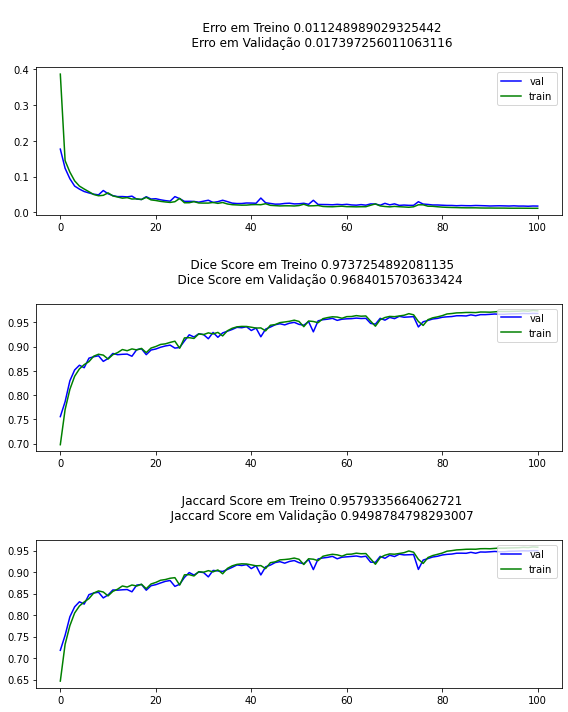


####################
Novo Checkpoint Salvo.
####################


CPU times: user 10min 8s, sys: 2min 3s, total: 12min 11s
Wall time: 8min 46s


In [24]:
%%time
treina_modelo.treinamento()

### Avaliação do Modelo

In [25]:
# Calcula os scores por classe
def compute_scores_per_classes(model, dataloader, classes):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = calcula_metrica_dice_por_classe(logits, targets)
            iou_scores = calcula_metrica_jaccard_por_classe(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [26]:
# Dataloader de validação
val_dataloader = prepara_dataloader(imgs_dir = config.path_to_imgs_dir,
                                    masks_dir = config.path_to_masks_dir,
                                    path_to_csv = config.path_to_csv,
                                    phase = "val",
                                    batch_size = 8,
                                    num_workers = 6,
                                    test_size = 0.2,)

In [27]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(modelo, 
                                                                             val_dataloader, 
                                                                             ['lung', 'heart', 'trachea'])

CPU times: user 46.9 s, sys: 8.28 s, total: 55.2 s
Wall time: 49.6 s


In [28]:
# Dataframe Dice
dice_df = pd.DataFrame(dice_scores_per_classes)

In [29]:
# Colunas do dataframe
dice_df.columns = ['lung dice', 'heart dice', 'trachea dice']

In [30]:
# IoU
iou_df = pd.DataFrame(iou_scores_per_classes)

In [31]:
# Colunas
iou_df.columns = ['lung jaccard', 'heart jaccard', 'trachea jaccard']

In [32]:
# Métricas de validação
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)

In [33]:
# Ajusta o dataframe
val_metics_df = val_metics_df.loc[:, ['lung dice', 'lung jaccard', 
                                      'heart dice', 'heart jaccard', 
                                      'trachea dice', 'trachea jaccard']]

In [34]:
# Visualiza
val_metics_df

,lung dice,lung jaccard,heart dice,heart jaccard,trachea dice,trachea jaccard
0,0.996953,0.993925,0.993187,0.986466,1.000000,1.000000
1,0.307692,0.181818,1.000000,1.000000,0.914460,0.842402
2,0.966951,0.936017,1.000000,1.000000,0.982185,0.964994
3,1.000000,1.000000,1.000000,1.000000,0.943973,0.893891
4,0.934411,0.876896,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
3337,0.988596,0.977450,1.000000,1.000000,1.000000,1.000000
3338,0.997600,0.995211,1.000000,1.000000,1.000000,1.000000
3339,0.994275,0.988614,1.000000,1.000000,0.968280,0.938511
3340,0.990581,0.981338,1.000000,1.000000,0.907992,0.831488


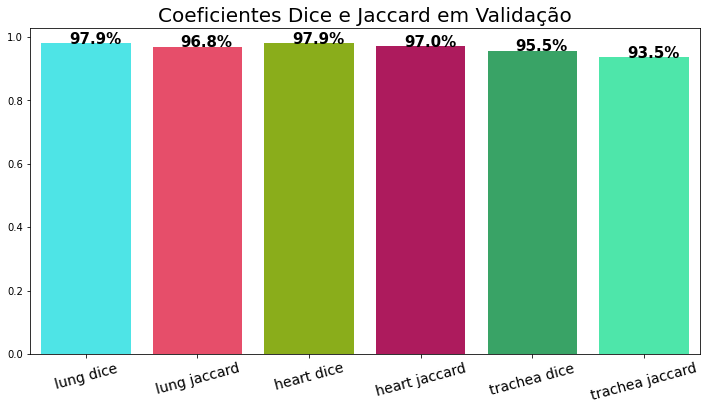

In [35]:
# Plot
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)
fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Coeficientes Dice e Jaccard em Validação", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("imagens/resultado1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')

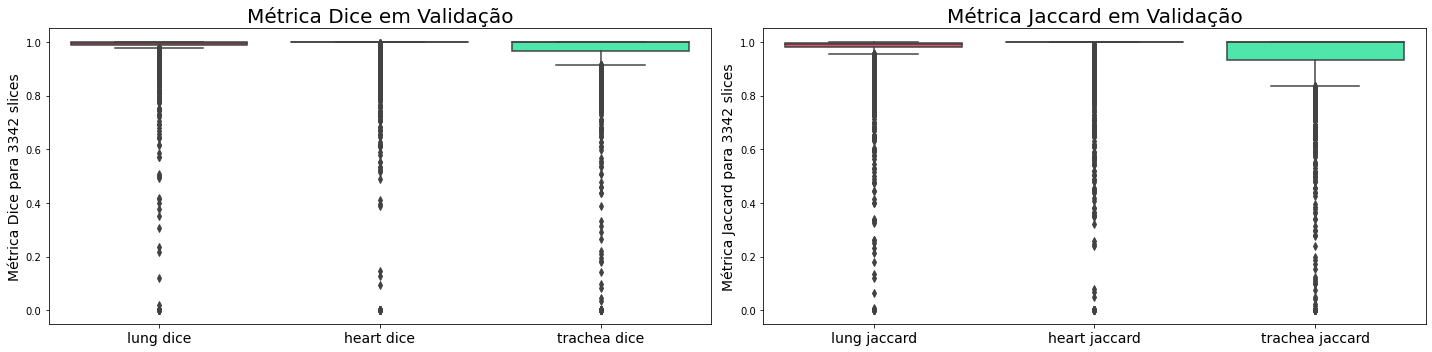

In [36]:
# Plot
colors = ['#35FCFF', '#FF355A', '#28B463', '#35FFAF', '#96C503', '#C5035B']
palette = sns.color_palette(colors[1::], 3)

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.boxplot(data = dice_df, palette = palette, ax = ax[0])
ax[0].set_ylabel("Métrica Dice para 3342 slices", fontsize = 14)
ax[0].set_title("Métrica Dice em Validação", fontsize = 20)
ax[0].set_xticklabels(dice_df.columns, fontsize = 14)

sns.boxplot(data = iou_df, palette = palette, ax = ax[1])
ax[1].set_ylabel("Métrica Jaccard para 3342 slices", fontsize = 14)
ax[1].set_title("Métrica Jaccard em Validação", fontsize = 20)
ax[1].set_xticklabels(iou_df.columns, fontsize=14)
plt.tight_layout()

fig.savefig("imagens/resultado2.png", format = "png",  pad_inches = 0.2, transparent = False, bbox_inches = 'tight')

In [37]:
# Logs de treino
train_logs = pd.read_csv(config.train_logs_path)
train_logs.head(5)

,train_loss,val_loss,train_dice,val_dice,train_jaccard,val_jaccard
0,0.386394,0.176678,0.697667,0.755589,0.646303,0.717975
1,0.144522,0.123104,0.769935,0.786307,0.731782,0.752826
2,0.112448,0.093943,0.811846,0.829476,0.775296,0.795960
3,0.087972,0.073344,0.838840,0.851835,0.804823,0.819167
4,0.073297,0.064866,0.854065,0.861600,0.821115,0.830928


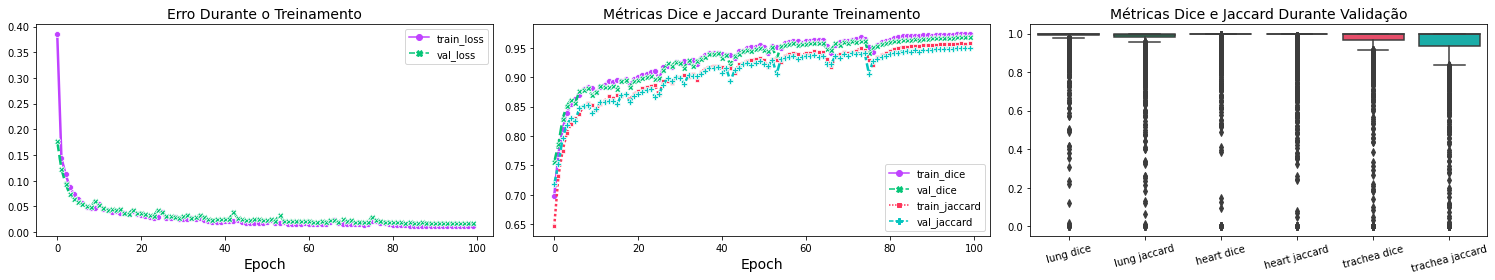

In [38]:
# Plot
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4), 
            sns.color_palette(colors[:2] + colors[-2:] + colors[2:-2], 6)]
            
fig, ax = plt.subplots(1, 3, figsize = (21, 4))

sns.lineplot(data=train_logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Erro Durante o Treinamento", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=train_logs.iloc[:, 2:], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Métricas Dice e Jaccard Durante Treinamento", fontsize=14)
ax[1].set_xlabel("Epoch", fontsize=14)

sns.boxplot(data=val_metics_df.iloc[:,:], palette=palettes[2], ax=ax[2])
ax[2].set_title("Métricas Dice e Jaccard Durante Validação", fontsize=14)
ax[2].set_xticklabels(val_metics_df.columns, fontsize=10, rotation=15)

plt.tight_layout()
fig.savefig("imagens/resultado3.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')

### Funções Para Geração de Vídeo

In [39]:
# Função para obter um slice
def get_slice(img_name: str,
              mask_name: str,
              root_imgs_path: str = "dados/images/",
              root_masks_path: str = "dados/masks/",) -> np.ndarray:

    img_path = os.path.join('/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/', img_name)
    print(img_path)
    mask_path = os.path.join('/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/', mask_name)
    print(mask_path)
    one_slice_img = cv2.imread(img_path)
    one_slice_mask = cv2.imread(mask_path)
    one_slice_mask[one_slice_mask < 240] = 0  
    one_slice_mask[one_slice_mask >= 240] = 255

    return one_slice_img, one_slice_mask

In [40]:
# Função para obter as previsões
def get_id_predictions(net: nn.Module,
                       ct_scan_id_df: pd.DataFrame,
                       root_imgs_dir: str,
                       treshold: float = 0.3) -> list:

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    images = []
    predictions = []
    net.eval()
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print("device:", device)
    
    with torch.no_grad():
        for idx in range(len(ct_scan_id_df)):
            img_name = ct_scan_id_df.loc[idx, "ImageId"]
            path = os.path.join(root_imgs_dir, img_name)

            img_ = cv2.imread(path)
    
            img = Normalize().apply(img_)
            tensor = torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0)
            prediction = net.forward(tensor.to(device))
            prediction = prediction.cpu().detach().numpy()
            prediction = prediction.squeeze(0).transpose(1, 2, 0)
            prediction = sigmoid(prediction)
            prediction = (prediction >= treshold).astype(np.float32)
            predictions.append((prediction * 255).astype("uint8"))
            images.append(img_)

    return images, predictions

In [41]:
# Função para sobrepor as máscaras nas imagens
def sobrepoe_imagem_mascara(one_slice_image: np.ndarray,
                            one_slice_mask: np.ndarray, 
                            w: float = 512,
                            h: float = 512, 
                            dpi: float = 100,
                            write: bool = False,
                            path_to_save: str = 'imagens/',
                            name_to_save: str = 'img_name'):

    # Caminho para salvar
    path_to_save_ = os.path.join(path_to_save, name_to_save)
    
    # Máscaras
    lung, heart, trachea = [one_slice_mask[:, :, i] for i in range(3)]
    
    # Figura
    figsize = (w / dpi), (h / dpi)
    fig = plt.figure(figsize=(figsize))
    fig.add_axes([0, 0, 1, 1])

    # Imagem
    plt.imshow(one_slice_image, cmap = "bone")

    # Mostra a sobreposição de imagens e máscaras
    plt.imshow(np.ma.masked_where(lung == False, lung), cmap='cool', alpha=0.3)
    plt.imshow(np.ma.masked_where(heart == False, heart), cmap='autumn', alpha=0.3)
    plt.imshow(np.ma.masked_where(trachea == False, trachea), cmap='autumn_r', alpha=0.3) 

    plt.axis('off')
    fig.savefig(f"{path_to_save_}.png", bbox_inches = 'tight', pad_inches = 0.0, dpi = dpi,  format = "png")
    if write:
        plt.close()
    else:
        plt.show()

In [42]:
# Função para sobreposição das máscaras
def sobrepoe_mascaras_full_ctscan(ct_scan_id_df: pd.DataFrame, path_to_save: str):

    num_slice = len(ct_scan_id_df)
    
    for slice_ in range(num_slice):

        print(slice_)
        
        img_name = ct_scan_id_df.loc[slice_, "ImageId"]
        mask_name = ct_scan_id_df.loc[slice_, "MaskId"]

        print(img_name)
        print(mask_name)
        
        # Obtém um slice de imagem e um slice de máscara
        one_slice_img, one_slice_mask = get_slice(img_name, mask_name)
        
        # Faz a sobreposição
        sobrepoe_imagem_mascara(one_slice_img,
                                    one_slice_mask,
                                    write = True, 
                                    path_to_save = path_to_save,
                                    name_to_save = str(slice_))

In [43]:
# Função para criação de video
def cria_video(path_to_imgs: str, video_name: str, framerate: int):

    img_names = sorted(os.listdir(path_to_imgs), key=lambda x: int(x[:-4])) 
    img_path = os.path.join(path_to_imgs, img_names[0])
    frame_width, frame_height, _ = cv2.imread(img_path).shape
    fourc = cv2.VideoWriter_fourcc(*'MP4V')
    video = cv2.VideoWriter(video_name + ".mp4", fourc, framerate, (frame_width, frame_height))

    for img_name in img_names:
        img_path = os.path.join(path_to_imgs, img_name)
        image = cv2.imread(img_path)
        video.write(image)
            
    cv2.destroyAllWindows()
    video.release()

In [44]:
# Obtém um ID
df = pd.read_csv(config.path_to_csv)
df["Id"] = df['ImageId'].apply(lambda x: x.split("_")[0])
id_ = 'ID00400637202305055099402'
full_scan_example = df.loc[df['Id'] == id_].reset_index(drop=True)
full_scan_example 

,ImageId,MaskId,Id
0,ID00400637202305055099402_0.jpg,ID00400637202305055099402_mask_0.jpg,ID00400637202305055099402
1,ID00400637202305055099402_1.jpg,ID00400637202305055099402_mask_1.jpg,ID00400637202305055099402
2,ID00400637202305055099402_2.jpg,ID00400637202305055099402_mask_2.jpg,ID00400637202305055099402
3,ID00400637202305055099402_3.jpg,ID00400637202305055099402_mask_3.jpg,ID00400637202305055099402
4,ID00400637202305055099402_4.jpg,ID00400637202305055099402_mask_4.jpg,ID00400637202305055099402
...,...,...,...
260,ID00400637202305055099402_260.jpg,ID00400637202305055099402_mask_260.jpg,ID00400637202305055099402
261,ID00400637202305055099402_261.jpg,ID00400637202305055099402_mask_261.jpg,ID00400637202305055099402
262,ID00400637202305055099402_262.jpg,ID00400637202305055099402_mask_262.jpg,ID00400637202305055099402
263,ID00400637202305055099402_263.jpg,ID00400637202305055099402_mask_263.jpg,ID00400637202305055099402


### Geração de Vídeo dos Labels Reais

In [45]:
# Caminho para salvar os vídeos
PATH_TO_SAVE = "videos/" + id_ + "_ground_truth"

In [46]:
# Salva a pasta do id do vídeo
if not os.path.exists(PATH_TO_SAVE):
    os.mkdir(PATH_TO_SAVE)
    print(f"Pasta {PATH_TO_SAVE} criada.")

Pasta videos/ID00400637202305055099402_ground_truth criada.


In [47]:
# Executa a função
sobrepoe_mascaras_full_ctscan(ct_scan_id_df = full_scan_example, path_to_save = PATH_TO_SAVE)

0
ID00400637202305055099402_0.jpg
ID00400637202305055099402_mask_0.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_0.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_0.jpg
1
ID00400637202305055099402_1.jpg
ID00400637202305055099402_mask_1.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_1.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_1.jpg
2
ID00400637202305055099402_2.jpg
ID00400637202305055099402_mask_2.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_2.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_2.jpg
3
ID00400637202305055099402_3.jpg
ID00400637202305055099402_mask_3.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_3.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/m

31
ID00400637202305055099402_31.jpg
ID00400637202305055099402_mask_31.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_31.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_31.jpg
32
ID00400637202305055099402_32.jpg
ID00400637202305055099402_mask_32.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_32.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_32.jpg
33
ID00400637202305055099402_33.jpg
ID00400637202305055099402_mask_33.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_33.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_33.jpg
34
ID00400637202305055099402_34.jpg
ID00400637202305055099402_mask_34.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_34.jpg
/media/datasets/IAMED/Cap09/Mi

62
ID00400637202305055099402_62.jpg
ID00400637202305055099402_mask_62.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_62.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_62.jpg
63
ID00400637202305055099402_63.jpg
ID00400637202305055099402_mask_63.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_63.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_63.jpg
64
ID00400637202305055099402_64.jpg
ID00400637202305055099402_mask_64.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_64.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_64.jpg
65
ID00400637202305055099402_65.jpg
ID00400637202305055099402_mask_65.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_65.jpg
/media/datasets/IAMED/Cap09/Mi

93
ID00400637202305055099402_93.jpg
ID00400637202305055099402_mask_93.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_93.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_93.jpg
94
ID00400637202305055099402_94.jpg
ID00400637202305055099402_mask_94.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_94.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_94.jpg
95
ID00400637202305055099402_95.jpg
ID00400637202305055099402_mask_95.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_95.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_95.jpg
96
ID00400637202305055099402_96.jpg
ID00400637202305055099402_mask_96.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_96.jpg
/media/datasets/IAMED/Cap09/Mi

124
ID00400637202305055099402_124.jpg
ID00400637202305055099402_mask_124.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_124.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_124.jpg
125
ID00400637202305055099402_125.jpg
ID00400637202305055099402_mask_125.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_125.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_125.jpg
126
ID00400637202305055099402_126.jpg
ID00400637202305055099402_mask_126.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_126.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_126.jpg
127
ID00400637202305055099402_127.jpg
ID00400637202305055099402_mask_127.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_127.jpg
/media/data

155
ID00400637202305055099402_155.jpg
ID00400637202305055099402_mask_155.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_155.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_155.jpg
156
ID00400637202305055099402_156.jpg
ID00400637202305055099402_mask_156.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_156.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_156.jpg
157
ID00400637202305055099402_157.jpg
ID00400637202305055099402_mask_157.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_157.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_157.jpg
158
ID00400637202305055099402_158.jpg
ID00400637202305055099402_mask_158.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_158.jpg
/media/data

186
ID00400637202305055099402_186.jpg
ID00400637202305055099402_mask_186.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_186.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_186.jpg
187
ID00400637202305055099402_187.jpg
ID00400637202305055099402_mask_187.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_187.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_187.jpg
188
ID00400637202305055099402_188.jpg
ID00400637202305055099402_mask_188.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_188.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_188.jpg
189
ID00400637202305055099402_189.jpg
ID00400637202305055099402_mask_189.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_189.jpg
/media/data

217
ID00400637202305055099402_217.jpg
ID00400637202305055099402_mask_217.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_217.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_217.jpg
218
ID00400637202305055099402_218.jpg
ID00400637202305055099402_mask_218.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_218.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_218.jpg
219
ID00400637202305055099402_219.jpg
ID00400637202305055099402_mask_219.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_219.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_219.jpg
220
ID00400637202305055099402_220.jpg
ID00400637202305055099402_mask_220.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_220.jpg
/media/data

248
ID00400637202305055099402_248.jpg
ID00400637202305055099402_mask_248.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_248.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_248.jpg
249
ID00400637202305055099402_249.jpg
ID00400637202305055099402_mask_249.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_249.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_249.jpg
250
ID00400637202305055099402_250.jpg
ID00400637202305055099402_mask_250.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_250.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/masks/masks/ID00400637202305055099402_mask_250.jpg
251
ID00400637202305055099402_251.jpg
ID00400637202305055099402_mask_251.jpg
/media/datasets/IAMED/Cap09/Mini-Projeto6/dados/images/images/ID00400637202305055099402_251.jpg
/media/data

In [48]:
%%time
cria_video(path_to_imgs = PATH_TO_SAVE, video_name = "videos/" + id_ + "_ground_truth", framerate = 30)

CPU times: user 1.85 s, sys: 24.5 ms, total: 1.87 s
Wall time: 1.87 s


### Geração de Vídeo das Previsões do Modelo

In [49]:
# Previsões
imgs, predictions = get_id_predictions(net = modelo,
                                       ct_scan_id_df = full_scan_example,
                                       root_imgs_dir = config.path_to_imgs_dir)

device: cuda


In [50]:
%%time
PATH_TO_SAVE = "videos/" + id_ + "_predictions"

if not os.path.exists(PATH_TO_SAVE):
    os.mkdir(PATH_TO_SAVE)
    print(f"Pasta {PATH_TO_SAVE} criada.")

_= [sobrepoe_imagem_mascara(one_slice_image = image,
                            one_slice_mask = mask, 
                            write = True,
                            path_to_save = PATH_TO_SAVE,
                            name_to_save = str(i_name)) 
    for i_name, (image, mask) in enumerate(zip(imgs, predictions))]

Pasta videos/ID00400637202305055099402_predictions criada.
CPU times: user 56.1 s, sys: 90.7 ms, total: 56.2 s
Wall time: 56.2 s


In [51]:
%%time
cria_video(path_to_imgs = PATH_TO_SAVE, 
           video_name = "videos/" + id_ + "_predictions", framerate = 30)

CPU times: user 1.82 s, sys: 32.3 ms, total: 1.85 s
Wall time: 1.85 s
